In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import string
import math
import seaborn as sns
from matplotlib.colors import LogNorm
import itertools
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
from matplotlib import cm
markers = itertools.cycle(['o','s','v',"X",'1'])


In [3]:
def makedf(filename,onwhich):
    df = pd.read_csv(filename, delimiter= '  ')
    df.columns = ['p', 'Pflow', 'Smax']
    pos1 = 0

    while filename[pos1] != onwhich and  pos1 < len(filename):
        pos1+=1
    pos2 = pos1 +1
    while pos2 < len(filename) and str(filename[pos2]).isnumeric():
        pos2+=1
    size = filename[pos1:pos2]
    df = df.sort_values(by=['p']).set_index(['p'])
    df = df[~df.index.duplicated(keep='first')]
    df.columns = pd.MultiIndex.from_product([df.columns, [size]])
    return df
makedf('./Ave_L10T10000.txt','L')

<ipython-input-3-249fe73da918>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename, delimiter= '  ')


FileNotFoundError: [Errno 2] No such file or directory: './Ave_L10T10000.txt'

<ipython-input-3-249fe73da918>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename, delimiter= '  ')
D:\Programy\MyAnacondaDont\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


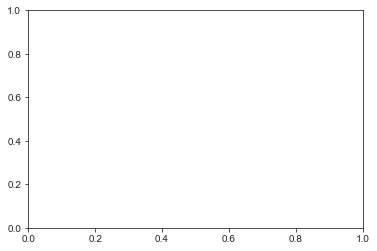

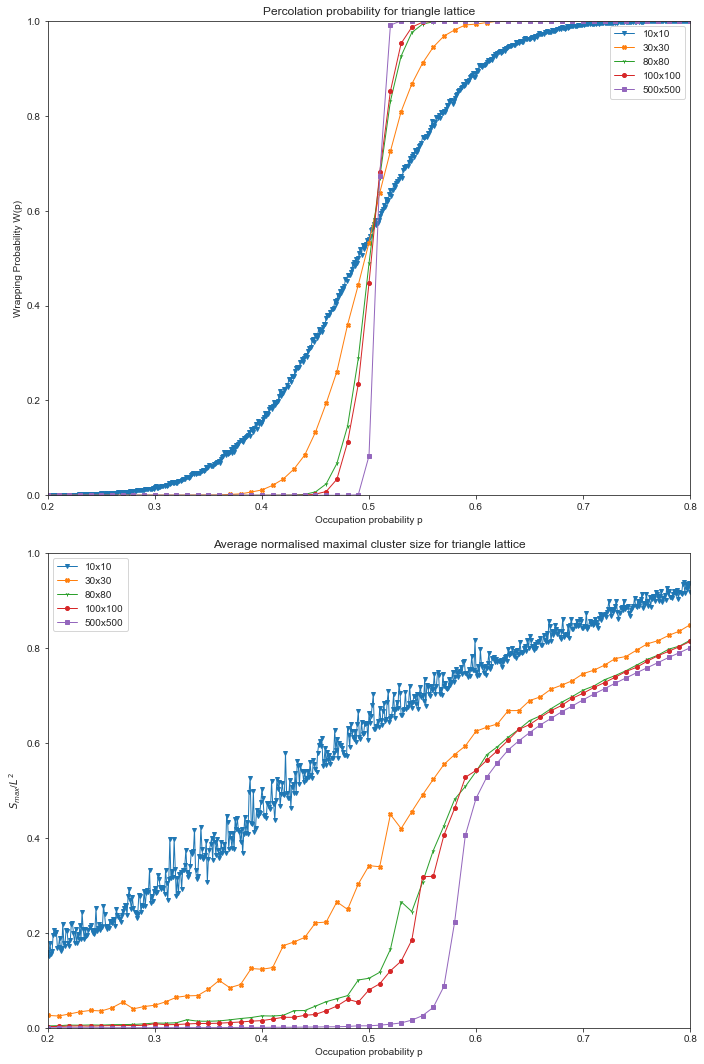

In [12]:
def readAverages(path, lat_type):
    df = pd.DataFrame()
    pax = [] 
    for filename in os.listdir(path):
        if (filename[-4:] == '.txt'):
            tmp = makedf(path + filename,"L")
            #if(len(tmp['p'])>len(pax)):
            #    pax = tmp['p']
            #df[tmp.columns] = tmp
            df = df.join(tmp,how = 'outer')
   # print(df)
    try:
        plt.clf()
        plt.cla()
        folder = path + 'images/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder + 'images/'))
    else:
        #print(df)
        proba_df = df.filter(regex = "Pflow")
        av_df = df.filter(regex = "Smax")
        # legend
        legend = [int(i[1][1:]) for i in proba_df.columns]
        proba_df.columns = legend
        av_df.columns = legend
        proba_df = proba_df.astype(float).sort_index(axis=1)
        av_df = av_df.astype(float).sort_index(axis=1)
        legend = [str(i) + "x" + str(i) for i in proba_df.columns]
    # -- PLOT --
        # probability first 
        sns.set_style("ticks")
        fig1, ax1 = plt.subplots(2,figsize=(10,15))
        #fig1.suptitle("Simulation for " + lat_type + " lattice")

        title = ("Percolation probability for " + lat_type + " lattice")
        
        for column in proba_df.columns:
            proba_df[column].dropna().plot(ax = ax1[0],
                         linewidth = 1,
                         marker = next(markers),
                         linestyle="-",
                         markersize = 4
                         )
        ax1[0].set(title = title,
                ylabel = 'Wrapping Probability W(p)',
                xlabel = 'Occupation probability p')
        # averages 
        for column in av_df.columns:
            av_df[column].dropna().plot(ax = ax1[1],
                         linewidth = 1,
                         linestyle="-",
                         marker = next(markers),
                         markersize = 4
                         )
        ax1[1].set(title='Average normalised maximal cluster size for ' + lat_type + " lattice",
                  ylabel="$S_{max}$/$L^2$",
                  xlabel='Occupation probability p')
        
        ax1[0].set_ylim(0, 1)
        ax1[1].set_ylim(0, 1)
        ax1[0].set_xlim(0.2, 0.8)
        ax1[1].set_xlim(0.2, 0.8)
        ax1[0].legend(legend)
        ax1[1].legend(legend)
        fig1.tight_layout(pad=1.5)
        plt.savefig(folder + title + ".pdf")
        return 
#readAverages('./square/', 'square')
readAverages('./triangle/', 'triangle')

In [105]:
def heatmap2d(which, labels, legend, title, directory):
    sns.set_style("ticks")
    # create grid
    x, y = np.meshgrid(np.linspace(0, len(labels) - 1, len(labels)), np.linspace(0, len(labels) - 1, len(labels)))
    # find max and min values
    z_max, z_min = which.max(), which.min()
    fig, ax = plt.subplots()
    # colormesh
    c = ax.imshow(which, interpolation='spline36', cmap='viridis_r', vmin=z_min, vmax=z_max)
    # c = ax.pcolor(x, y, which,shading='auto', cmap='YlGnBu', vmin=z_min, vmax=z_max)
    # plt.imshow(arr, cmap='viridis')

    # axis set
    ax.set(title=title + "," + legend,
           ylabel="n(k)")
    ax.axis([x.min(), x.max(), y.min(), y.max()])
    ax.set_xticks(range(0, len(labels)))
    ax.set_xticklabels(labels)
    ax.set_yticks(range(0, len(labels)))
    ax.set_yticklabels(labels)
    ax.legend([legend]
              , frameon=False
              , loc='lower left'
              , fontsize=5
              , bbox_to_anchor=(1.05, 1))
    fig.colorbar(c, ax=ax)
    plt.tight_layout()
    plt.savefig(directory + title + "," + legend + ".svg")

<ipython-input-165-904492653d0c>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


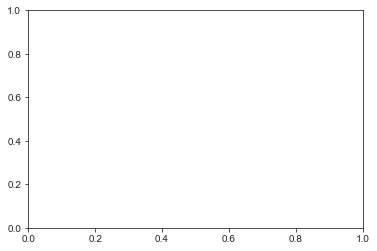

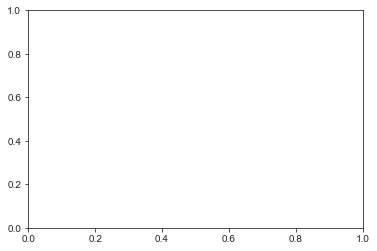

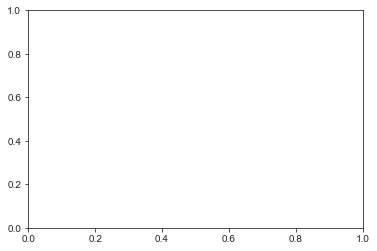

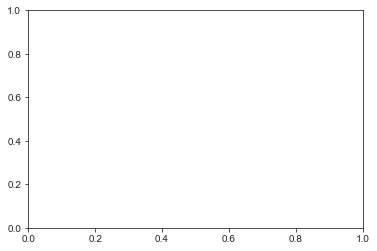

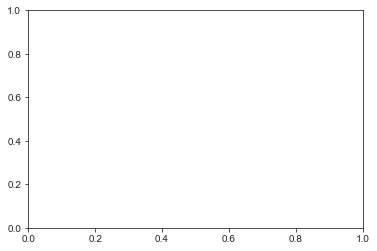

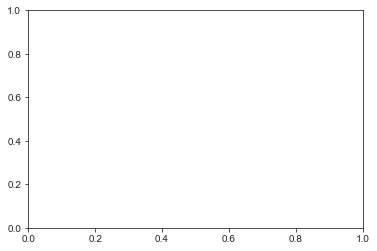

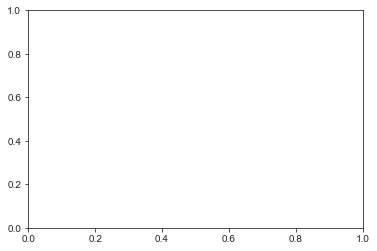

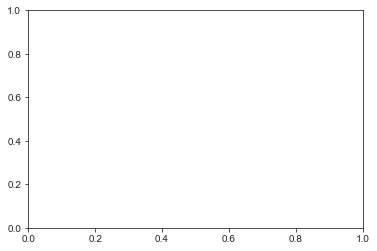

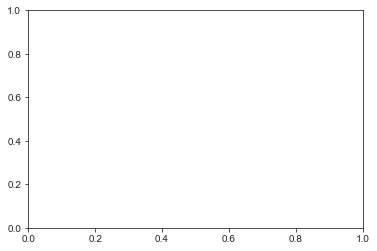

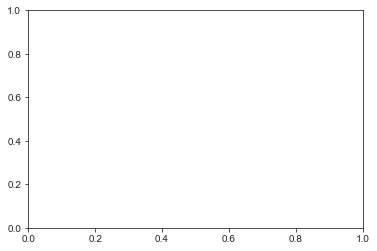

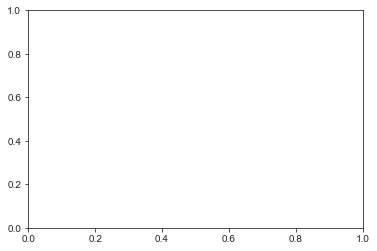

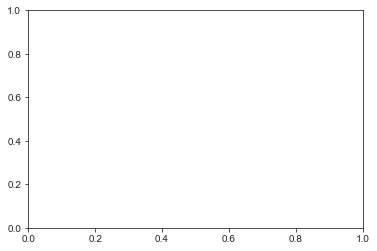

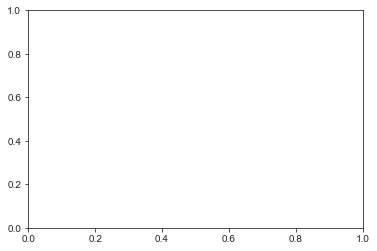

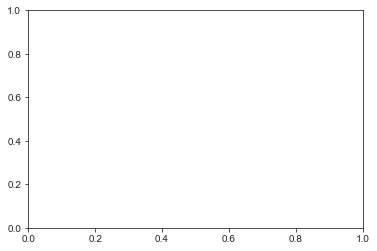

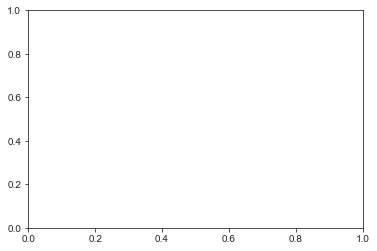

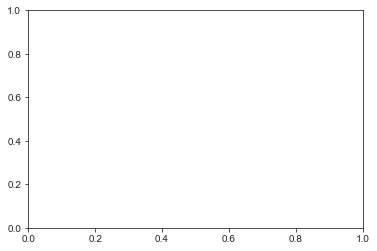

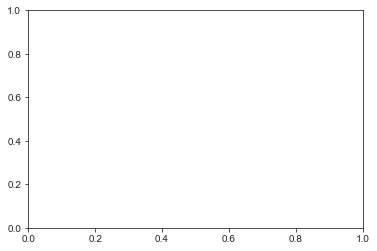

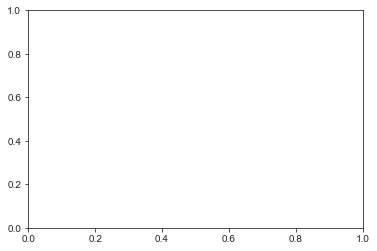

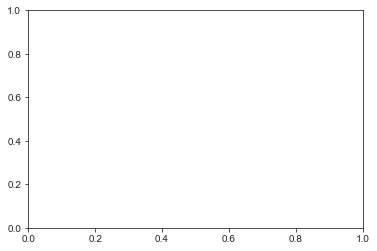

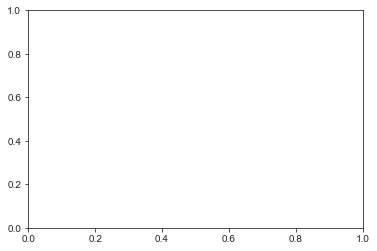

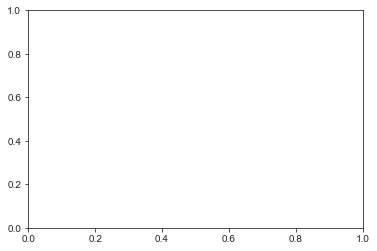

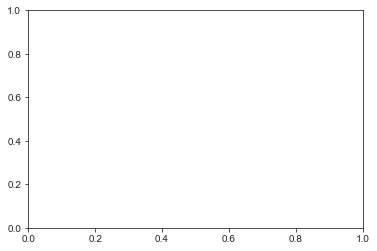

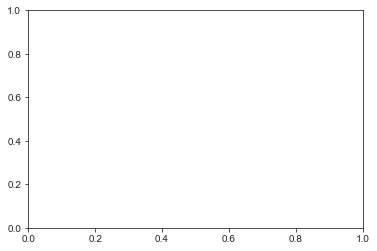

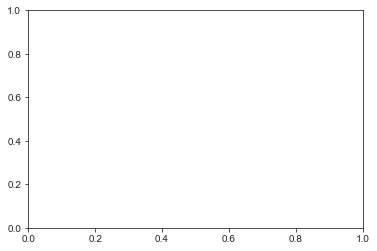

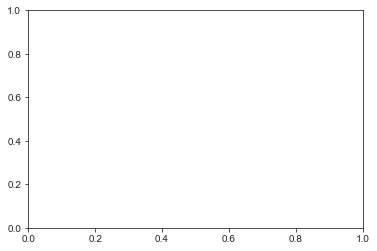

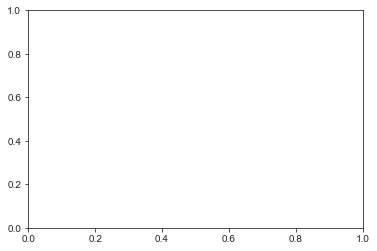

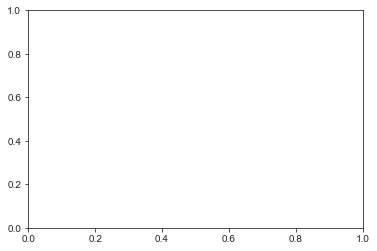

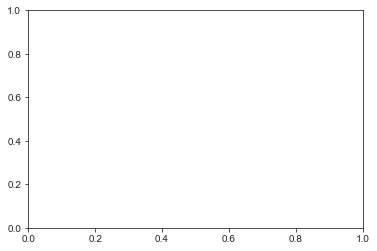

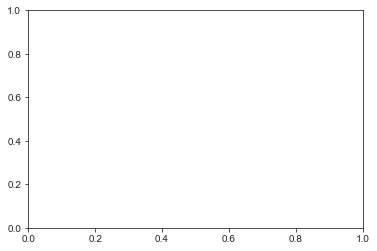

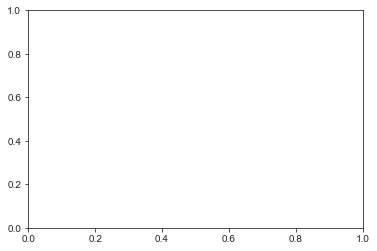

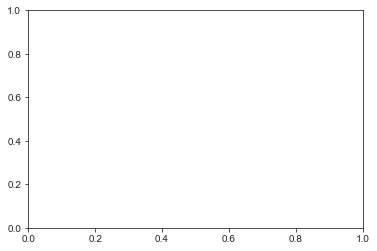

In [165]:
def imgFromConfig(directory, size, lat_type: str,mode:str):
    try:
        plt.clf()
        plt.cla()
        folder = directory +  'images/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        for filename in os.listdir(directory):
            max_size = 400,400
            if (filename[-4:] == '.txt'):
                fig, ax = plt.subplots()
                ar = np.loadtxt(directory + filename)
                maximum = np.max(ar)
                #print(maximum)
                ar = ar / maximum
                if(mode == 'fire'):
                    ar = cm.afmhot(ar)
                else:
                    ar = cm.cividis(ar)
                #print(filename)
                #print(ar)
                formatted = ( (ar*255).astype('uint8'))
                img = Image.fromarray(formatted)
                img = img.resize(max_size, resample=Image.BOX)
                img.save(folder + filename[:-4] + '.png')
                img.convert('RGB').save(folder + filename[:-4] + '.eps')
      
imgFromConfig('./square/ClusterPictures/L500/',500,'square','other')
imgFromConfig('./square/BurnedPictures/L500/',500,'square','fire')        
imgFromConfig('./triangle/ClusterPictures/L500/',500,'triangle','other')
imgFromConfig('./triangle/BurnedPictures/L500/',500,'triangle','fire')

<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmax" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cm" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer suppor

<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmax" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cm" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer suppor

<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmax" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cm" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
<ipython-input-123-c626930c0907>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "vmin" which is no longer suppor

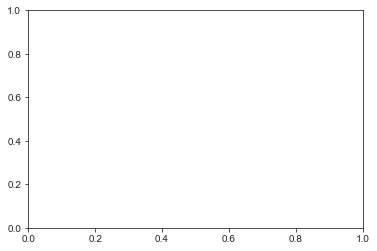

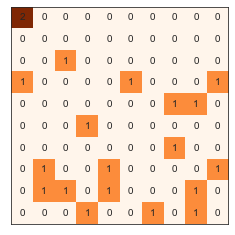

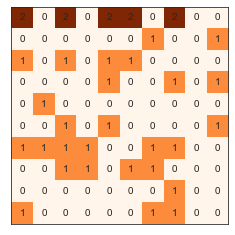

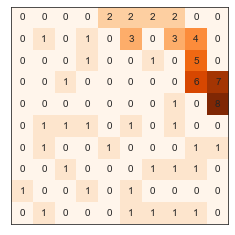

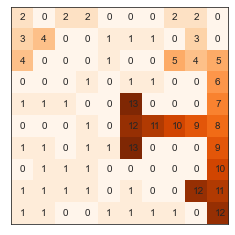

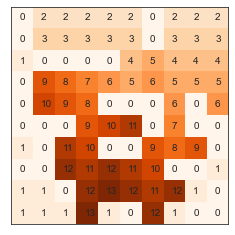

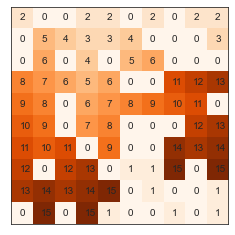

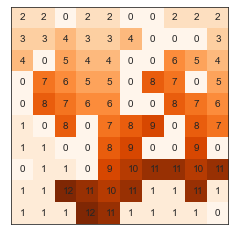

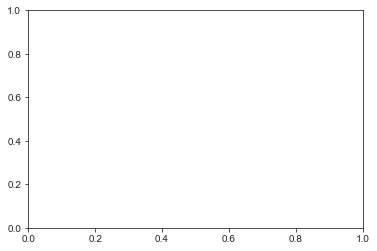

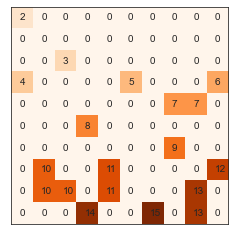

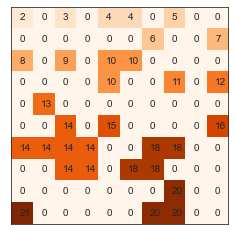

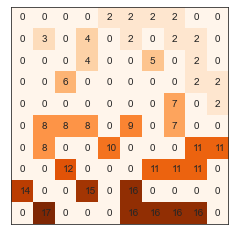

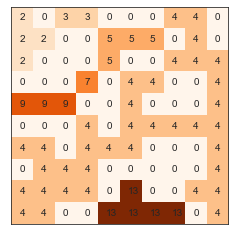

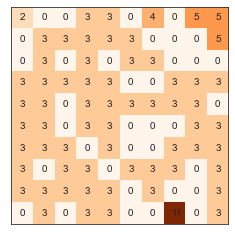

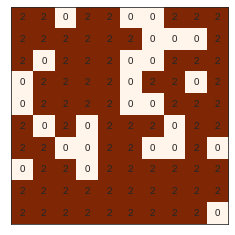

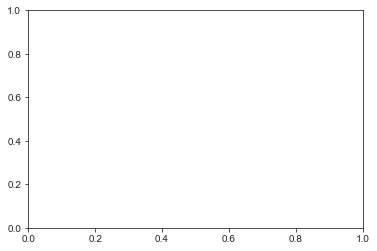

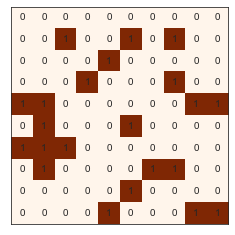

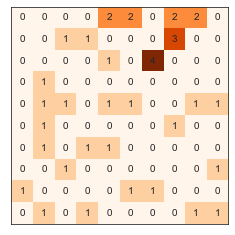

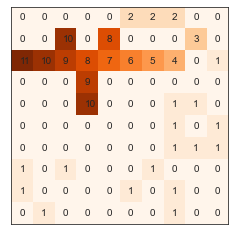

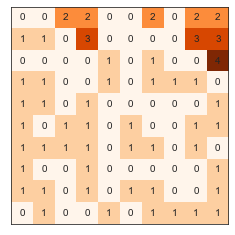

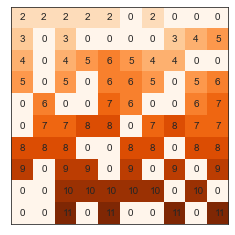

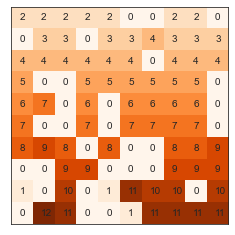

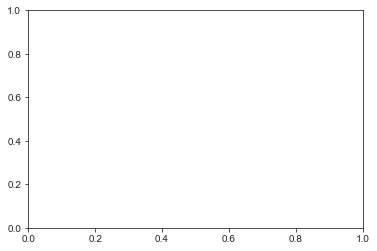

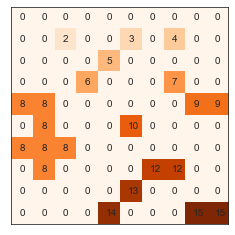

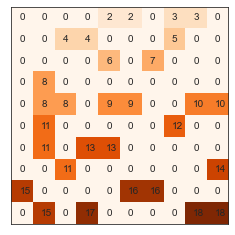

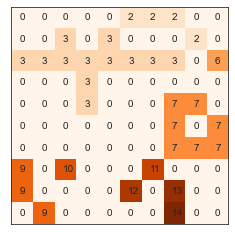

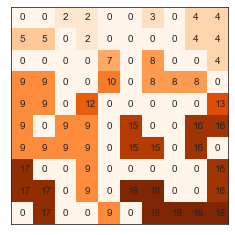

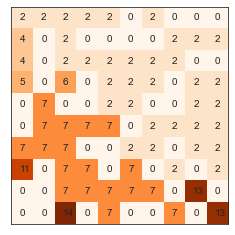

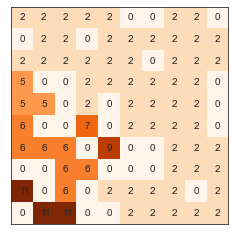

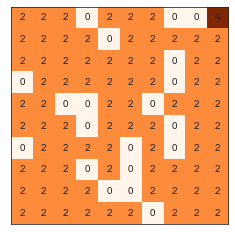

In [123]:
def imgFromConfigPoints(directory, size, lat_type: str,mode:str):
    try:
        plt.clf()
        plt.cla()
        folder = directory +  'images/withNumbers/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        for filename in os.listdir(directory):
            if (filename[-4:] == '.txt'):
                fig, ax = plt.subplots()
                # load file
                ar = np.loadtxt(directory + filename)
                # create array
                x = [i for i in range(0,len(ar))]
                y = [i for i in range(0,len(ar))]
                flatar = ar.flatten()
                ax.scatter(x, y, marker = '' )
                for i in range(0,len(x)):
                    for j in range(0,len(y)):
                        elem = j*len(ar) + i
                        plt.text(x[i]-.1,y[j]+0.1,str(int(flatar[elem])))
                        #x.annotate(flatar[elem],(x[i],y[j]) )
                maximum = np.max(ar)
                ar = ar / maximum
                ar = cm.Oranges(ar)
                ar = ( (ar*255).astype('uint8'))
                # to image
                
                plt.gca().set_xticks([])
                plt.gca().set_xticklabels([])
                plt.gca().set_yticks([])
                plt.gca().set_yticklabels([])
                plt.imshow(ar, interpolation='none')
                #plt.savefig(folder + filename[:-4] + '.pdf',vmin = 0, vmax = 255, cm='Oranges')
                plt.savefig(folder + filename[:-4] + '.png',vmin = 0, vmax = 255, cm='Oranges')
imgFromConfigPoints('./square/BurnedPictures/L10/',10,'square','fire')
imgFromConfigPoints('./square/ClusterPictures/L10/',10,'square','other')
imgFromConfigPoints('./triangle/BurnedPictures/L10/',10,'triangle','fire')
imgFromConfigPoints('./triangle/ClusterPictures/L10/',10,'triangle','other')

In [147]:

def makedfDist(filename,onwhich):
    df = pd.read_csv(filename,header=None, delimiter= '  ')
    #print(df)
    df.columns = ['s', 'N(s)']
    pos1 = 0
    while filename[pos1] != onwhich and  pos1 < len(filename):
        pos1+=1
    pos2 = pos1 +1
    while pos2 < len(filename) and str(filename[pos2]).isnumeric() or str(filename[pos2]) =="." :
        pos2+=1
    size = filename[pos1:pos2]
    df = df.set_index(['s'])
    df = df[~df.index.duplicated(keep='first')]
   # print(df)
    df.columns = [size]
    return df

<ipython-input-147-cb7ebeb28547>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(filename,header=None, delimiter= '  ')


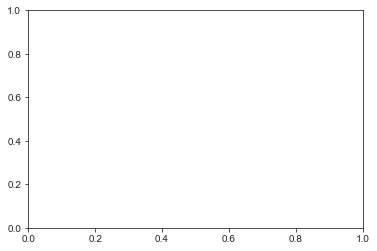

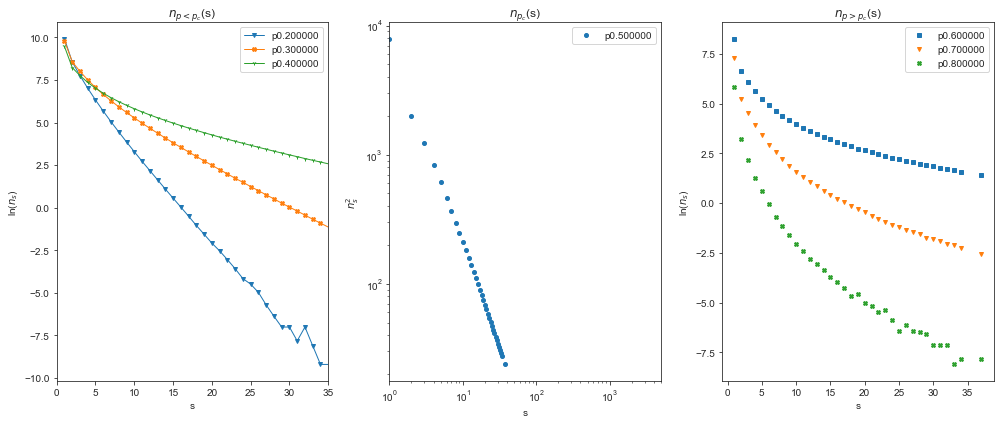

In [168]:
def pow2(x):
    return x*x
def plotDistribut(path, lat_type, L):
    df = pd.DataFrame()
    for filename in os.listdir(path):
        if (filename[-4:] == '.txt'):
            tmp = makedfDist(path + filename,'p')
            #print(tmp)
            df[tmp.columns] = tmp[tmp.columns]
            #df =
    try:
        #print(df)
        plt.clf()
        plt.cla()
        folder = path + 'images/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder + 'images/'))
    else:
        # legend
        #print(df)
        legend = [i for i in df.columns]
        cols_under = []
        cols_over = []
        col_crit = []
        if lat_type == "square":
            for elem in legend:
                if float(elem[1:]) < 0.592746:
                    cols_under.append(elem)
                elif float(elem[1:]) > 0.592746:
                    cols_over.append(elem)
                else:
                    col_crit.append(elem)
        else:
             for elem in legend:
                if float(elem[1:]) < 0.5:
                    cols_under.append(elem)
                elif float(elem[1:]) > 0.5:
                    cols_over.append(elem)
                else:
                    col_crit.append(elem)
        #df=df.dropna()
        df.columns = legend
        df_under = df[cols_under].apply(np.log,axis=1).replace([-np.inf],np.nan).dropna()
        #print(df_under)
        df_over = df[cols_over].apply(np.log,axis=1).replace([-np.inf],np.nan).dropna()
        #print(df_over)
        df_crit = df[col_crit]#.apply(lambda x: x*L*L,axis=1).replace([0.0],np.nan).dropna()
        #print(df_crit)
    # -- PLOT --
        # probability first 
        sns.set_style("ticks")
        fig1, (ax1,ax2,ax3) = plt.subplots(1,3,sharey=False,figsize=(14, 6))
        

        #atitle = ("Percolation probability for " + lat_type + " lattice")
        #fig1.suptitle("Cluster size distribution for " + lat_type + " lattice on and L = " + str(L) )
        for column in df_under.columns:
            df_under[column].dropna().plot(ax = ax1,
                         linewidth = 1,
                         marker = next(markers),
                         markersize = 4,
                         )


        for column in df_crit.columns:
            df_crit[column].dropna().plot(ax = ax2,
                         linewidth = 0,
                         marker = next(markers),
                         markersize = 4,
                                  logx=True,
                                  logy=True
                                 
                         )


        for column in df_over.columns:
            df_over[column].dropna().plot(ax = ax3,
                         linewidth = 0,
                         marker = next(markers),
                         markersize = 4,
                         )
            
        ax1.set(title = '$n_{p<p_c}$(s)',
        ylabel = 'ln($n_s$)',
        xlabel = 's')
        ax1.set_xlim(0,35)
        #ax1.set_ylim(-15,10)
        ax1.legend(df_under.columns)
        
        ax2.set(title='$n_{p_c}$(s)',
          ylabel="$n_s^2$",
          xlabel='s')
        ax2.set_xlim(1,5e3)
        #ax2.set_ylim(1e-3,1e5)
        ax2.legend(df_crit.columns)
        #print(df_crit)
        ax3.set(title='$n_{p>p_c}$(s)',
                  ylabel='ln($n_s$)',
                  xlabel='s')
        #ax3.set_xlim(0,30)
        #ax3.set_ylim(-15,10)
        ax3.legend(df_over.columns)

        fig1.tight_layout()
        plt.savefig(folder + 'distribution' + ".pdf")
        return #df_crit

plotDistribut('./triangle/Distributions/L500/','triangle',500)